In [2]:
import tensorflow as tf
from keras.layers import Conv2D, LeakyReLU, Input, MaxPooling2D, Activation, Concatenate, Dropout, Lambda, Add, UpSampling2D
from keras.models import Model, Sequential
import keras

import cycleganstyletransfer










In [37]:
#Environmnet stuff
ROOT_PATH = "./"
MODEL_NAME = "LowFidelityGAN_V1"


In [55]:
#Make the dataset
from cycleganstyletransfer.config import DATA_DIR
data_dir = DATA_DIR / "raw"


my_monet_ds_train, my_monet_ds_val = tf.keras.utils.image_dataset_from_directory(
    data_dir / "Monet",
    validation_split=0.1,
    subset="both",
    seed=42,
    image_size=(128, 128),
    batch_size = 1,
    labels = None,
)

my_image_ds_train, my_image_ds_val = tf.keras.utils.image_dataset_from_directory(
    data_dir / "Images",
    validation_split=0.1,
    subset="both",
    seed=42,
    image_size=(128, 128),
    batch_size = 1,
    labels = None,
)

Found 1193 files belonging to 1 classes.
Using 1074 files for training.
Using 119 files for validation.
Found 7037 files belonging to 1 classes.
Using 6334 files for training.
Using 703 files for validation.


In [56]:

"""
my_monet_ds_train = (
  my_monet_ds_train
  .cache()
  .shuffle(1000)
  .repeat()
  .prefetch(AUTOTUNE)
)

my_image_ds_train = (
  my_image_ds_train
  .cache()
  .shuffle(1000)
  .repeat() 
)
"""
my_monet_ds_val = iter(my_monet_ds_val)
my_image_ds_val = iter(my_image_ds_val)

In [42]:
class InstanceNormalization(keras.layers.Layer):
    def __init__(self, epsilon=1e-5, **kwargs):
        super(InstanceNormalization, self).__init__(**kwargs)
        self.epsilon = epsilon

    def build(self, input_shape):
        # One scale and bias per channel
        self.gamma = self.add_weight(
            shape=(input_shape[-1],),
            initializer='ones',
            trainable=True,
            name='gamma'
        )
        self.beta = self.add_weight(
            shape=(input_shape[-1],),
            initializer='zeros',
            trainable=True,
            name='beta'
        )
        super(InstanceNormalization, self).build(input_shape)

    def call(self, inputs):
        # Compute mean and variance per instance, per channel
        mean, variance = tf.nn.moments(inputs, axes=[1, 2], keepdims=True)
        normalized = (inputs - mean) / tf.sqrt(variance + self.epsilon)
        return self.gamma * normalized + self.beta

    def get_config(self):
        config = super().get_config().copy()
        config.update({"epsilon": self.epsilon})
        return config


In [43]:
def build_discriminator(input_shape=(128, 128, 3)):
    inputs = Input(shape=input_shape)

    x = Conv2D(64, kernel_size=4, strides=2, padding='same')(inputs)
    x = LeakyReLU(0.2)(x)

    x = Conv2D(128, kernel_size=4, strides=2, padding='same')(x)
    x = InstanceNormalization()(x)
    x = LeakyReLU(0.2)(x)

    x = Conv2D(256, kernel_size=4, strides=2, padding='same')(x)
    x = InstanceNormalization()(x)
    x = LeakyReLU(0.2)(x)

    x = Conv2D(512, kernel_size=4, strides=1, padding='same')(x)
    x = InstanceNormalization()(x)
    x = LeakyReLU(0.2)(x)

    x = Conv2D(1, kernel_size=4, strides=1, padding='same')(x)

    return Model(inputs, x, name='PatchGAN_70x70')


In [44]:
def build_weak_discriminator(input_shape=(128, 128, 3)):
    inputs = Input(shape=input_shape)

    x = Conv2D(64, kernel_size=4, strides=2, padding='same')(inputs)
    x = LeakyReLU(0.2)(x)

    x = Conv2D(128, kernel_size=4, strides=2, padding='same')(x)
    x = InstanceNormalization()(x)
    x = LeakyReLU(0.2)(x)

    x = Conv2D(256, kernel_size=4, strides=2, padding='same')(x)
    x = InstanceNormalization()(x)
    x = LeakyReLU(0.2)(x)

    x = Conv2D(1, kernel_size=4, strides=1, padding='same')(x)

    return Model(inputs, x, name='PatchGAN_70x70')




In [45]:
# === Reflection Padding ===
def ReflectionPad2D(pad):
    return Lambda(lambda x: tf.pad(x, [[0, 0], [pad, pad], [pad, pad], [0, 0]], mode='REFLECT'))

In [46]:
# === Residual Block ===
def ResidualBlock(filters, kernel_size=3):
    pad = kernel_size // 2
    def block(x):
        y = ReflectionPad2D(pad)(x)
        y = Conv2D(filters, kernel_size, padding='valid')(y)
        y = InstanceNormalization()(y)
        y = Activation('relu')(y)

        y = ReflectionPad2D(pad)(y)
        y = Conv2D(filters, kernel_size, padding='valid')(y)
        y = InstanceNormalization()(y)

        return Add()([x, y])
    return block
##No activation at the end ?!

In [47]:
def Generator(input_shape=(128, 128, 3), n_res_blocks=6):
    inputs = Input(shape=input_shape)

    # Encoder
    x = ReflectionPad2D(3)(inputs)
    x = Conv2D(64, kernel_size=7, padding='valid')(x)
    x = InstanceNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, kernel_size=3, strides=2, padding='same')(x)
    x = InstanceNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, kernel_size=3, strides=2, padding='same')(x)
    x = InstanceNormalization()(x)
    x = Activation('relu')(x)

    # Residual Blocks
    for _ in range(n_res_blocks):
        x = ResidualBlock(256)(x)

    # Decoder
    x = UpSampling2D(size=(2, 2), interpolation='bilinear')(x)
    x = Conv2D(128, kernel_size=3, padding='same')(x)
    x = InstanceNormalization()(x)
    x = Activation('relu')(x)

    x = UpSampling2D(size=(2, 2), interpolation='bilinear')(x)
    x = Conv2D(64, kernel_size=3, padding='same')(x)
    x = InstanceNormalization()(x)
    x = Activation('relu')(x)

    x = ReflectionPad2D(3)(x)
    x = Conv2D(3, kernel_size=7, padding='valid', activation='tanh')(x)

    return Model(inputs, x, name='JohnsonGenerator')



In [81]:
from keras.optimizers import Adam

# === TRACKERS ===
current_epoch = tf.Variable(0, dtype=tf.int64)
global_step = tf.Variable(0, dtype=tf.int64)


# Optimizers for all models
monet_gen_opt = Adam(0.0, beta_1=0.5)
photo_gen_opt = Adam(0.0, beta_1=0.5)
monet_disc_opt = Adam(0.0, beta_1=0.5)
photo_disc_opt = Adam(0.0, beta_1=0.5)

# Initialize models
monet_generator = Generator((128, 128, 3))
photo_generator = Generator((128, 128, 3))
monet_discriminator = build_weak_discriminator()
photo_discriminator = build_discriminator()


In [86]:
global ckpt, ckpt_manager  # make them global

ckpt_og = tf.train.Checkpoint(
    monet_generator=monet_generator,
    photo_generator=photo_generator,
    monet_discriminator=monet_discriminator,
    photo_discriminator=photo_discriminator,
    monet_gen_opt=monet_gen_opt,
    photo_gen_opt=photo_gen_opt,
    monet_disc_opt=monet_disc_opt,
    photo_disc_opt=photo_disc_opt
)

In [ ]:
load_list = [
    [ckpt_og, "LowFidelityGAN_V1", "ckpt-5"],
    [ckpt_og, "LowFidelityGAN_V1", "ckpt-10"],
    [ckpt_og, "LowFidelityGAN_V1", "ckpt-14"],
    [ckpt_pivot, "LowFidelityGAN_V1_Pivot", "ckpt-4"],
    [ckpt_pivot, "LowFidelityGAN_V1_Pivot", "ckpt-10"],
    [ckpt_pivot, "LowFidelityGAN_V1_Pivot", "ckpt-13"],
    [ckpt_decay, "LowFidelityGAN_V1_Decay", "ckpt-2"],
    [ckpt_decay, "LowFidelityGAN_V1_Decay", "ckpt-5"],
    [ckpt_decay, "LowFidelityGAN_V1_Decay", "ckpt-9"],
]

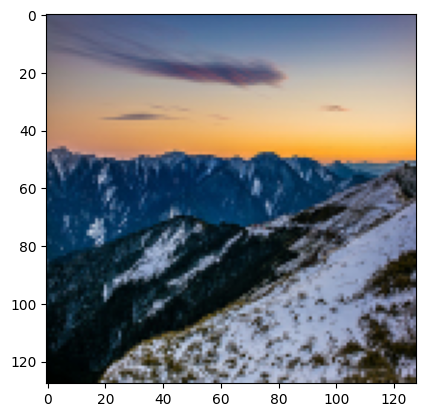

In [87]:
#import tensorflow as tf
import matplotlib.pyplot as plt

test_img = next(my_image_ds_val)
plt.imshow(test_img[0] / 255)


In [88]:
def setup_cyclegan_checkpoint():
    """
    Sets up CycleGAN checkpoint manager using global models & ALL FOUR optimizers.
    Uses these global variables:
      monet_generator, photo_generator,
      monet_discriminator, photo_discriminator,
      monet_gen_opt, photo_gen_opt, monet_disc_opt, photo_disc_opt
    """
    global ckpt, ckpt_manager  # make them global

    ckpt = tf.train.Checkpoint(
        monet_generator=monet_generator,
        photo_generator=photo_generator,
        monet_discriminator=monet_discriminator,
        photo_discriminator=photo_discriminator,
        monet_gen_opt=monet_gen_opt,
        photo_gen_opt=photo_gen_opt,
        monet_disc_opt=monet_disc_opt,
        photo_disc_opt=photo_disc_opt
    )

    ckpt_manager = tf.train.CheckpointManager(
        ckpt,
        f"{ROOT_PATH}/checkpoints/{MODEL_NAME}",
        max_to_keep=10
    )

    if ckpt_manager.latest_checkpoint:
        ckpt.restore(ckpt_manager.latest_checkpoint)
        print(f"✅ Restored from {ckpt_manager.latest_checkpoint}")
    else:
        print("🚀 Training from scratch.")


In [90]:
setup_cyclegan_checkpoint()

✅ Restored from .//checkpoints/LowFidelityGAN_V1\ckpt-14


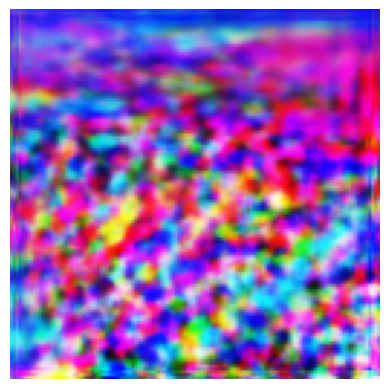

In [89]:
output = monet_generator(test_img)
    
# Display the generated image
plt.figure()
#plt.title(f"Checkpoint: {thing[1]} - {thing[2]}")
plt.imshow((output[0] + 1)/2)
plt.axis('off')
plt.show()


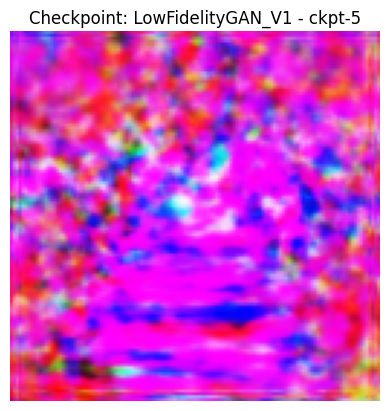

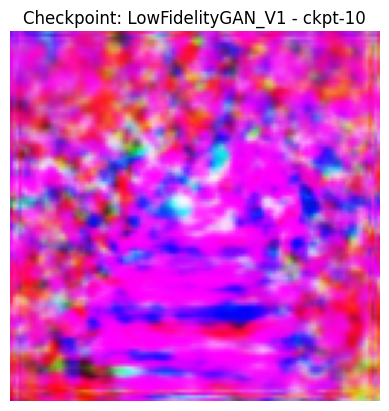

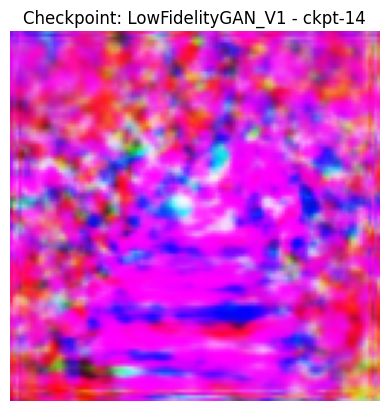

In [ ]:
for thing in load_list:
    thing[0].restore(f"./checkpoints/{thing[1]}/{thing[2]}").expect_partial()
    # Generate output using the loaded checkpoint's monet generator
    output = monet_generator(test_img)
    
    # Display the generated image
    plt.figure()
    plt.title(f"Checkpoint: {thing[1]} - {thing[2]}")
    plt.imshow((output[0] + 1)/2)
    plt.axis('off')
    plt.show()


In [ ]:
def setup_cyclegan_checkpoint():
    """
    Sets up CycleGAN checkpoint manager using global models & ALL FOUR optimizers.
    Uses these global variables:
      monet_generator, photo_generator,
      monet_discriminator, photo_discriminator,
      monet_gen_opt, photo_gen_opt, monet_disc_opt, photo_disc_opt
    """
    global ckpt, ckpt_manager, current_epoch  # make them global

    # Ensure epoch is a tf.Variable if not already set
    if 'current_epoch' not in globals():
        current_epoch = tf.Variable(1, name="epoch", trainable=False)

    ckpt = tf.train.Checkpoint(
        monet_generator=monet_generator,
        photo_generator=photo_generator,
        monet_discriminator=monet_discriminator,
        photo_discriminator=photo_discriminator,
        monet_gen_opt=monet_gen_opt,
        photo_gen_opt=photo_gen_opt,
        monet_disc_opt=monet_disc_opt,
        photo_disc_opt=photo_disc_opt,
        epoch=current_epoch
    )

    ckpt_manager = tf.train.CheckpointManager(
        ckpt,
        f"{ROOT_PATH}/checkpoints/{MODEL_NAME}",
        max_to_keep=10
    )

    if ckpt_manager.latest_checkpoint:
        ckpt.restore(ckpt_manager.latest_checkpoint).expect_partial()
        print(f"✅ Restored from {ckpt_manager.latest_checkpoint} (epoch {int(current_epoch.numpy())})")
    else:
        print("🚀 Training from scratch.")
